In [1]:
%pip install temporian -q


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [126]:
from datetime import timedelta
import json
import os
import urllib.request

from pathlib import Path
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from temporian.core.data.duration_utils import convert_timestamps_to_datetimes
import matplotlib.pyplot as plt
import pandas as pd
import temporian as tp

seed = 0

In [127]:
data_path = Path('tmp/temporian_taxi.csv')
if not os.path.exists(data_path):
    urllib.request.urlretrieve("https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv", data_path)

labels_path = Path('tmp/temporian_taxi_labels.csv')
if not os.path.exists(labels_path):
    urllib.request.urlretrieve("https://raw.githubusercontent.com/numenta/NAB/master/labels/combined_labels.json", labels_path)

In [128]:
df = pd.read_csv(data_path, parse_dates=["timestamp"])
df

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


In [129]:
with open(labels_path) as f:
    outliers = list(pd.to_datetime(pd.Series(json.load(f)['realKnownCause/nyc_taxi.csv'])))
outliers

[Timestamp('2014-11-01 19:00:00'),
 Timestamp('2014-11-27 15:30:00'),
 Timestamp('2014-12-25 15:00:00'),
 Timestamp('2015-01-01 01:00:00'),
 Timestamp('2015-01-27 00:00:00')]

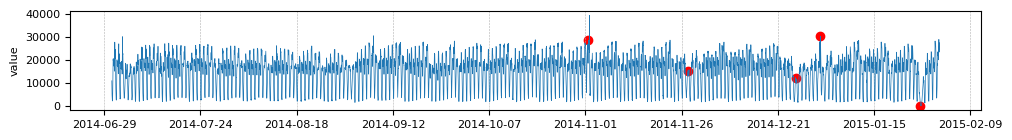

In [130]:
evset.plot()
plt.scatter(sorted(convert_timestamps_to_datetimes(outliers)), df[df["timestamp"].isin(outliers)]["value"], c="red")

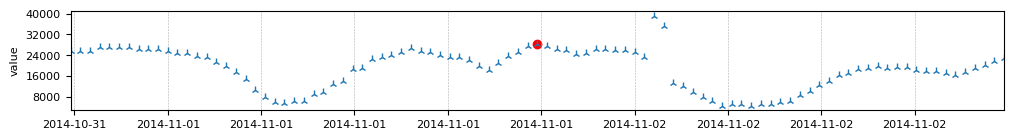

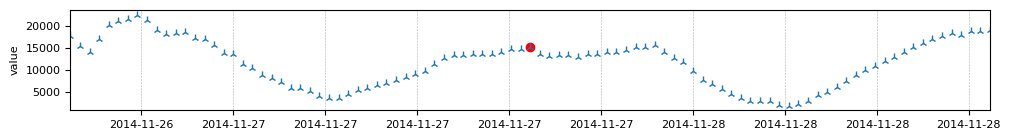

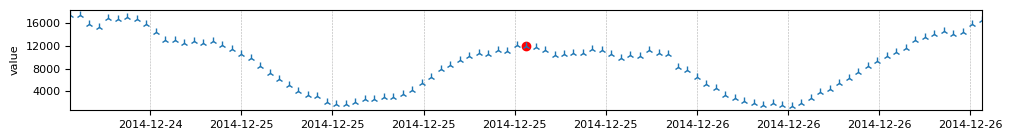

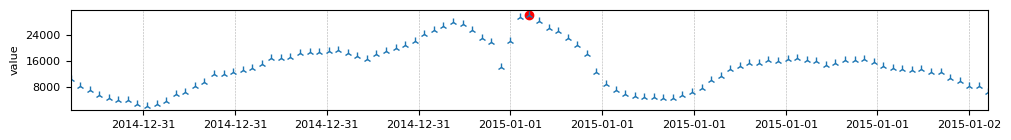

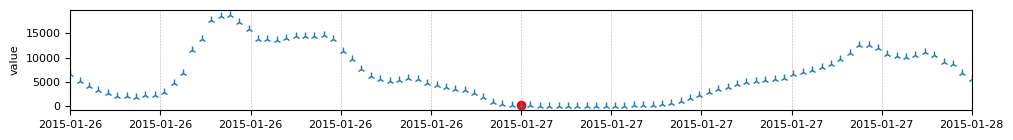

In [131]:
for outlier in outliers:
    evset = tp.from_pandas(df)
    evset.plot(min_time=outlier - timedelta(days=1), max_time=outlier + timedelta(days=1), style="marker")
    plt.scatter(sorted(convert_timestamps_to_datetimes([outlier])), df[df["timestamp"] == outlier]["value"], c="red")

In [132]:
contamination = len(outliers) / len(df) * 4
contamination

0.001937984496124031

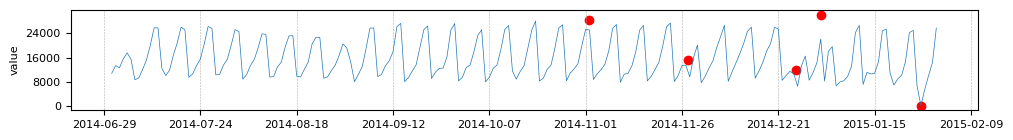

In [133]:
sampling = evset.tick(interval=tp.duration.days(1))
evset_daily = evset.resample(sampling)
evset_daily.plot()
plt.scatter(sorted(convert_timestamps_to_datetimes(outliers)), df[df["timestamp"].isin(outliers)]["value"], c="red")

In [134]:
def fit_and_eval(timestamps, evset):
    features = tp.to_pandas(evset)
    print(features)
    print("Fitting IsolationForest to features of shape", features.shape)
    model = IsolationForest(contamination=contamination, n_estimators=1000, random_state=seed)
    preds = model.fit_predict(features)
    preds = set(timestamps[preds == -1])
    print("True outliers:", outliers)
    print("Outliers predicted:", preds)
    correct_outliers = preds.intersection(outliers)
    print(f"Correct outliers predicted: {len(correct_outliers)}/{len(outliers)}")
    evset[["value"]].plot()
    plt.scatter(sorted(convert_timestamps_to_datetimes(preds)), df[df["timestamp"].isin(preds)]["value"], c="red")

In [135]:
def fit_and_eval_lof(timestamps, evset):
    features = tp.to_pandas(evset)
    print(features)
    print("Fitting LocalOutlierFactor to features of shape", features.shape)
    model = LocalOutlierFactor(n_neighbors=50, contamination=contamination)
    preds = model.fit_predict(features)
    preds = set(timestamps[preds == -1])
    print("True outliers:", outliers)
    print("Outliers predicted:", preds)
    correct_outliers = preds.intersection(outliers)
    print(f"Correct outliers predicted: {len(correct_outliers)}/{len(outliers)}")
    evset[["value"]].plot()
    plt.scatter(sorted(convert_timestamps_to_datetimes(preds)), df[df["timestamp"].isin(preds)]["value"], c="red")

       value     timestamp
0      10844  1.404173e+09
1       8127  1.404175e+09
2       6210  1.404176e+09
3       4656  1.404178e+09
4       3820  1.404180e+09
...      ...           ...
10315  24670  1.422740e+09
10316  25721  1.422742e+09
10317  27309  1.422743e+09
10318  26591  1.422745e+09
10319  26288  1.422747e+09

[10320 rows x 2 columns]
Fitting IsolationForest to features of shape (10320, 2)
True outliers: [Timestamp('2014-11-01 19:00:00'), Timestamp('2014-11-27 15:30:00'), Timestamp('2014-12-25 15:00:00'), Timestamp('2015-01-01 01:00:00'), Timestamp('2015-01-27 00:00:00')]
Outliers predicted: {Timestamp('2015-01-31 22:30:00'), Timestamp('2015-01-01 01:00:00'), Timestamp('2015-01-31 18:30:00'), Timestamp('2015-01-10 23:30:00'), Timestamp('2015-01-30 20:00:00'), Timestamp('2015-01-30 22:00:00'), Timestamp('2015-01-30 19:30:00'), Timestamp('2014-07-02 19:30:00'), Timestamp('2015-01-27 01:00:00'), Timestamp('2015-01-31 19:30:00'), Timestamp('2014-07-01 18:30:00'), Timestamp('20

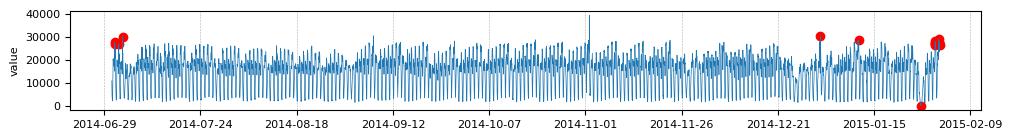

In [136]:
timestamps = df["timestamp"]

features = tp.from_pandas(df)

fit_and_eval(timestamps, features)

In [137]:
calendar_features = []

calendar_features.append(evset.calendar_day_of_month().rename("day_of_month"))
calendar_features.append(evset.calendar_day_of_week().rename("day_of_week"))
calendar_features.append(evset.calendar_month().rename("month"))
calendar_features.append(evset.calendar_year().rename("year"))

features = tp.glue(evset, *calendar_features)
features

timestamp,value,day_of_month,day_of_week,month,year
2014-07-01 00:00:00+00:00,10844,1,1,7,2014
2014-07-01 00:30:00+00:00,8127,1,1,7,2014
2014-07-01 01:00:00+00:00,6210,1,1,7,2014
2014-07-01 01:30:00+00:00,4656,1,1,7,2014
2014-07-01 02:00:00+00:00,3820,1,1,7,2014
2014-07-01 02:30:00+00:00,2873,1,1,7,2014
2014-07-01 03:00:00+00:00,2369,1,1,7,2014
2014-07-01 03:30:00+00:00,2064,1,1,7,2014
2014-07-01 04:00:00+00:00,2221,1,1,7,2014
2014-07-01 04:30:00+00:00,2158,1,1,7,2014


       value        sma_6h        sma_1d        sma_1w        sma_4w  lag_30m  \
0      10844  10844.000000  10844.000000  10844.000000  10844.000000        0   
1       8127   9485.500000   9485.500000   9485.500000   9485.500000    10844   
2       6210   8393.666992   8393.666992   8393.666992   8393.666992     8127   
3       4656   7459.250000   7459.250000   7459.250000   7459.250000     6210   
4       3820   6731.399902   6731.399902   6731.399902   6731.399902     4656   
...      ...           ...           ...           ...           ...      ...   
10315  24670  24322.500000  18715.646484  12860.928711  14421.754883    23719   
10316  25721  24710.250000  18694.437500  12864.988281  14425.818359    24670   
10317  27309  25326.000000  18703.500000  12871.833008  14431.215820    25721   
10318  26591  25815.666016  18696.478516  12874.661133  14436.278320    27309   
10319  26288  26040.083984  18702.478516  12875.732422  14440.216797    26591   

       lag_1h  lag_2h  lag_

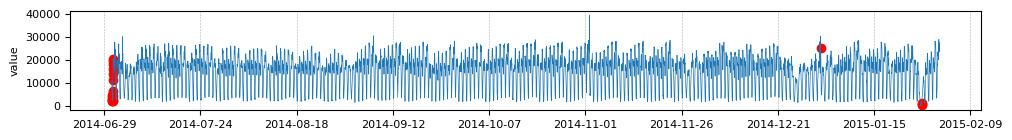

In [148]:
fit_and_eval(timestamps, features)

In [140]:
lag_features = []

lag_features.append(evset.lag(tp.duration.minutes(30)).resample(evset).rename("lag_30m"))
lag_features.append(evset.lag(tp.duration.hours(1)).resample(evset).rename("lag_1h"))
lag_features.append(evset.lag(tp.duration.hours(2)).resample(evset).rename("lag_2h"))
lag_features.append(evset.lag(tp.duration.days(1)).resample(evset).rename("lag_1d"))
lag_features.append(evset.lag(tp.duration.days(2)).resample(evset).rename("lag_2d"))
lag_features.append(evset.lag(tp.duration.weeks(1)).resample(evset).rename("lag_1w"))
lag_features.append(evset.lag(tp.duration.weeks(2)).resample(evset).rename("lag_2w"))
lag_features.append(evset.lag(tp.duration.weeks(4)).resample(evset).rename("lag_4w"))

features = tp.glue(evset, *lag_features, *calendar_features)
features

timestamp,value,lag_30m,lag_1h,lag_2h,lag_1d,lag_2d,lag_1w,lag_2w,lag_4w,day_of_month,day_of_week,month,year
2014-07-01 00:00:00+00:00,10844,0,0,0,0,0,0,0,0,1,1,7,2014
2014-07-01 00:30:00+00:00,8127,10844,0,0,0,0,0,0,0,1,1,7,2014
2014-07-01 01:00:00+00:00,6210,8127,10844,0,0,0,0,0,0,1,1,7,2014
2014-07-01 01:30:00+00:00,4656,6210,8127,0,0,0,0,0,0,1,1,7,2014
2014-07-01 02:00:00+00:00,3820,4656,6210,10844,0,0,0,0,0,1,1,7,2014
2014-07-01 02:30:00+00:00,2873,3820,4656,8127,0,0,0,0,0,1,1,7,2014
2014-07-01 03:00:00+00:00,2369,2873,3820,6210,0,0,0,0,0,1,1,7,2014
2014-07-01 03:30:00+00:00,2064,2369,2873,4656,0,0,0,0,0,1,1,7,2014
2014-07-01 04:00:00+00:00,2221,2064,2369,3820,0,0,0,0,0,1,1,7,2014
2014-07-01 04:30:00+00:00,2158,2221,2064,2873,0,0,0,0,0,1,1,7,2014


       value  lag_30m  lag_1h  lag_2h  lag_1d  lag_2d  lag_1w  lag_2w  lag_4w  \
0      10844        0       0       0       0       0       0       0       0   
1       8127    10844       0       0       0       0       0       0       0   
2       6210     8127   10844       0       0       0       0       0       0   
3       4656     6210    8127       0       0       0       0       0       0   
4       3820     4656    6210   10844       0       0       0       0       0   
...      ...      ...     ...     ...     ...     ...     ...     ...     ...   
10315  24670    23719   23291   27773   26432   23188   21588   22661   18891   
10316  25721    24670   23719   24985   26739   22638   24357   23754   20259   
10317  27309    25721   24670   23291   26874   21501   25009   25114   20055   
10318  26591    27309   25721   23719   26928   20719   25641   25308   19787   
10319  26288    26591   27309   24670   26000   17877   25928   25251   20995   

       day_of_month  day_of

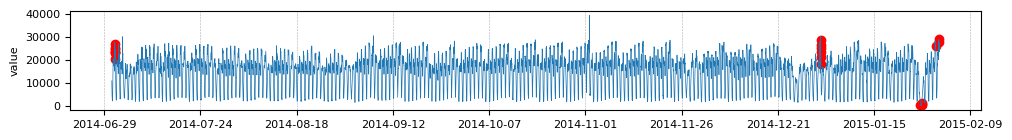

In [141]:
fit_and_eval(timestamps, features)

In [142]:
moving_features = []

value = evset.cast(tp.float32)
moving_features.append(value.simple_moving_average(window_length=tp.duration.hours(6)).rename("sma_6h"))
moving_features.append(value.simple_moving_average(window_length=tp.duration.days(1)).rename("sma_1d"))
moving_features.append(value.simple_moving_average(window_length=tp.duration.weeks(1)).rename("sma_1w"))
moving_features.append(value.simple_moving_average(window_length=tp.duration.weeks(4)).rename("sma_4w"))

features = tp.glue(evset, *moving_features, *lag_features, *calendar_features)
features

timestamp,value,sma_6h,sma_1d,sma_1w,sma_4w,lag_30m,lag_1h,lag_2h,lag_1d,lag_2d,lag_1w,lag_2w,lag_4w,day_of_month,day_of_week,month,year
2014-07-01 00:00:00+00:00,10844,1.084e+04,1.084e+04,1.084e+04,1.084e+04,0,0,0,0,0,0,0,0,1,1,7,2014
2014-07-01 00:30:00+00:00,8127,9486,9486,9486,9486,10844,0,0,0,0,0,0,0,1,1,7,2014
2014-07-01 01:00:00+00:00,6210,8394,8394,8394,8394,8127,10844,0,0,0,0,0,0,1,1,7,2014
2014-07-01 01:30:00+00:00,4656,7459,7459,7459,7459,6210,8127,0,0,0,0,0,0,1,1,7,2014
2014-07-01 02:00:00+00:00,3820,6731,6731,6731,6731,4656,6210,10844,0,0,0,0,0,1,1,7,2014
2014-07-01 02:30:00+00:00,2873,6088,6088,6088,6088,3820,4656,8127,0,0,0,0,0,1,1,7,2014
2014-07-01 03:00:00+00:00,2369,5557,5557,5557,5557,2873,3820,6210,0,0,0,0,0,1,1,7,2014
2014-07-01 03:30:00+00:00,2064,5120,5120,5120,5120,2369,2873,4656,0,0,0,0,0,1,1,7,2014
2014-07-01 04:00:00+00:00,2221,4798,4798,4798,4798,2064,2369,3820,0,0,0,0,0,1,1,7,2014
2014-07-01 04:30:00+00:00,2158,4534,4534,4534,4534,2221,2064,2873,0,0,0,0,0,1,1,7,2014


       value        sma_6h        sma_1d        sma_1w        sma_4w  lag_30m  \
0      10844  10844.000000  10844.000000  10844.000000  10844.000000        0   
1       8127   9485.500000   9485.500000   9485.500000   9485.500000    10844   
2       6210   8393.666992   8393.666992   8393.666992   8393.666992     8127   
3       4656   7459.250000   7459.250000   7459.250000   7459.250000     6210   
4       3820   6731.399902   6731.399902   6731.399902   6731.399902     4656   
...      ...           ...           ...           ...           ...      ...   
10315  24670  24322.500000  18715.646484  12860.928711  14421.754883    23719   
10316  25721  24710.250000  18694.437500  12864.988281  14425.818359    24670   
10317  27309  25326.000000  18703.500000  12871.833008  14431.215820    25721   
10318  26591  25815.666016  18696.478516  12874.661133  14436.278320    27309   
10319  26288  26040.083984  18702.478516  12875.732422  14440.216797    26591   

       lag_1h  lag_2h  lag_

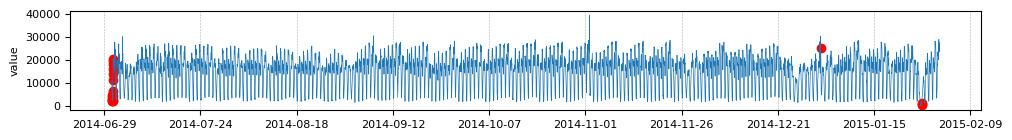

In [143]:
fit_and_eval(timestamps, features)

       value        sma_6h        sma_1d        sma_1w        sma_4w  lag_30m  \
0      10844  10844.000000  10844.000000  10844.000000  10844.000000        0   
1       8127   9485.500000   9485.500000   9485.500000   9485.500000    10844   
2       6210   8393.666992   8393.666992   8393.666992   8393.666992     8127   
3       4656   7459.250000   7459.250000   7459.250000   7459.250000     6210   
4       3820   6731.399902   6731.399902   6731.399902   6731.399902     4656   
...      ...           ...           ...           ...           ...      ...   
10315  24670  24322.500000  18715.646484  12860.928711  14421.754883    23719   
10316  25721  24710.250000  18694.437500  12864.988281  14425.818359    24670   
10317  27309  25326.000000  18703.500000  12871.833008  14431.215820    25721   
10318  26591  25815.666016  18696.478516  12874.661133  14436.278320    27309   
10319  26288  26040.083984  18702.478516  12875.732422  14440.216797    26591   

       lag_1h  lag_2h  lag_

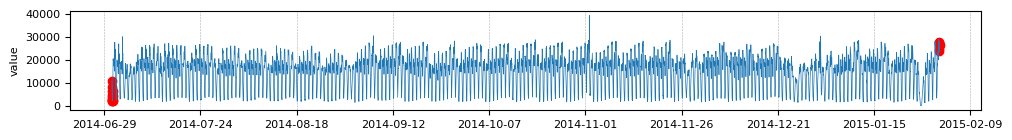

In [146]:
fit_and_eval_lof(timestamps, features)